In [1]:
import math
import torch
import pickle
import torch.cuda
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as dsets
import os
from utils.BBBConvmodel import BBBAlexNet, BBBLeNet, BBB3Conv3FC
from utils.BBBlayers import GaussianVariationalInference
import numpy as np
from scipy.stats import norm
cuda = torch.cuda.is_available()
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
batch_size = 32
lr = 0.001
dataset = 'MNIST'
network = 'lenet'
model = torch.load("../results/{}_b{}_lr{}_{}.pth".format(network, batch_size, lr, dataset))
net = BBBLeNet
num_samples = 10
beta_type = "Blundell"

In [3]:
model.state_dict().keys()

odict_keys(['conv1.qw_mean', 'conv1.qw_logvar', 'conv1.conv_qw_mean', 'conv1.conv_qw_si', 'conv1.log_alpha', 'conv2.qw_mean', 'conv2.qw_logvar', 'conv2.conv_qw_mean', 'conv2.conv_qw_si', 'conv2.log_alpha', 'fc1.qw_mean', 'fc1.qw_logvar', 'fc1.fc_qw_mean', 'fc1.fc_qw_si', 'fc1.log_alpha', 'fc2.qw_mean', 'fc2.qw_logvar', 'fc2.fc_qw_mean', 'fc2.fc_qw_si', 'fc2.log_alpha', 'fc3.qw_mean', 'fc3.qw_logvar', 'fc3.fc_qw_mean', 'fc3.fc_qw_si', 'fc3.log_alpha', 'layers.0.qw_mean', 'layers.0.qw_logvar', 'layers.0.conv_qw_mean', 'layers.0.conv_qw_si', 'layers.0.log_alpha', 'layers.3.qw_mean', 'layers.3.qw_logvar', 'layers.3.conv_qw_mean', 'layers.3.conv_qw_si', 'layers.3.log_alpha', 'layers.7.qw_mean', 'layers.7.qw_logvar', 'layers.7.fc_qw_mean', 'layers.7.fc_qw_si', 'layers.7.log_alpha', 'layers.9.qw_mean', 'layers.9.qw_logvar', 'layers.9.fc_qw_mean', 'layers.9.fc_qw_si', 'layers.9.log_alpha', 'layers.11.qw_mean', 'layers.11.qw_logvar', 'layers.11.fc_qw_mean', 'layers.11.fc_qw_si', 'layers.11.log_

# all_layers

In [4]:
w_name = ['layers.0.qw_', 'layers.3.qw_', 'layers.7.qw_','layers.9.qw_', 'layers.11.qw_']
b_name = ['layers.0.qb_', 'layers.3.qb_', 'layers.7.qb_','layers.9.qb_', 'layers.11.qb_']

In [5]:
model = model.cpu()

In [7]:
whole_w = []
for (i, j) in zip(w_name, b_name):
# for i in w_name:
    whole_w.append(model.state_dict()['{}mean'.format(i)].numpy().ravel())
    whole_w.append(model.state_dict()['{}mean'.format(j)].numpy().ravel())
whole_w = np.concatenate(whole_w)

In [8]:
len(whole_w)

61470

In [9]:
len(whole_w[np.abs(whole_w) <= 1e-2])

7292

## GMM拟合all layers

In [10]:
from sklearn.mixture import GaussianMixture
import random
import numpy as np

# 设置随机种子
seed = 42
np.random.seed(seed)
random.seed(seed)

# 定义要尝试的n_components值
n_min = 2
n_components_range = range(n_min, 6)

# 初始化信息准则列表
aic_scores = []
bic_scores = []

# 计算每个n_components值上的信息准则值
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(whole_w.reshape(-1,1))
    aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
    # bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

# 选择具有最小信息准则值的n_components值
best_n_components_aic = np.argmin(aic_scores) + n_min
# best_n_components_bic = np.argmin(bic_scores) + n_min

print("Best n_components (AIC):", best_n_components_aic)
# print("Best n_components (BIC):", best_n_components_bic)

gmm = GaussianMixture(n_components=best_n_components_aic)
gmm.fit(whole_w.reshape(-1,1))

Best n_components (AIC): 2


GaussianMixture(n_components=2)

In [11]:
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)

[[ 0.03961964]
 [-0.03691067]]
[[[0.00327525]]

 [[0.00308765]]]
[0.49755192 0.50244808]


## 广义高斯拟合all layers

In [12]:
import numpy as np
from scipy.optimize import minimize
import math

def generalized_gaussian(params, data):
    beta, mu, alpha = params
    n = len(data)
    # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
    log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
    return -log_likelihood

def estimate_generalized_gaussian_parameters(data):
    # Initial parameter guess
    initial_params = [1, np.mean(data), np.std(data)]

    # Define the optimization function
    optimization_func = lambda params: generalized_gaussian(params, data)

    # Perform the optimization
    result = minimize(optimization_func, initial_params, method='Nelder-Mead')

    # Extract the optimized parameters
    beta, mu, alpha = result.x

    return beta, mu, alpha

In [13]:
def log_GGD_pdf (mu,alpha,beta,x):
    return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)

In [14]:
beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

## 柯西拟合all_layers

In [15]:
from scipy.stats import cauchy
cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

## 画图

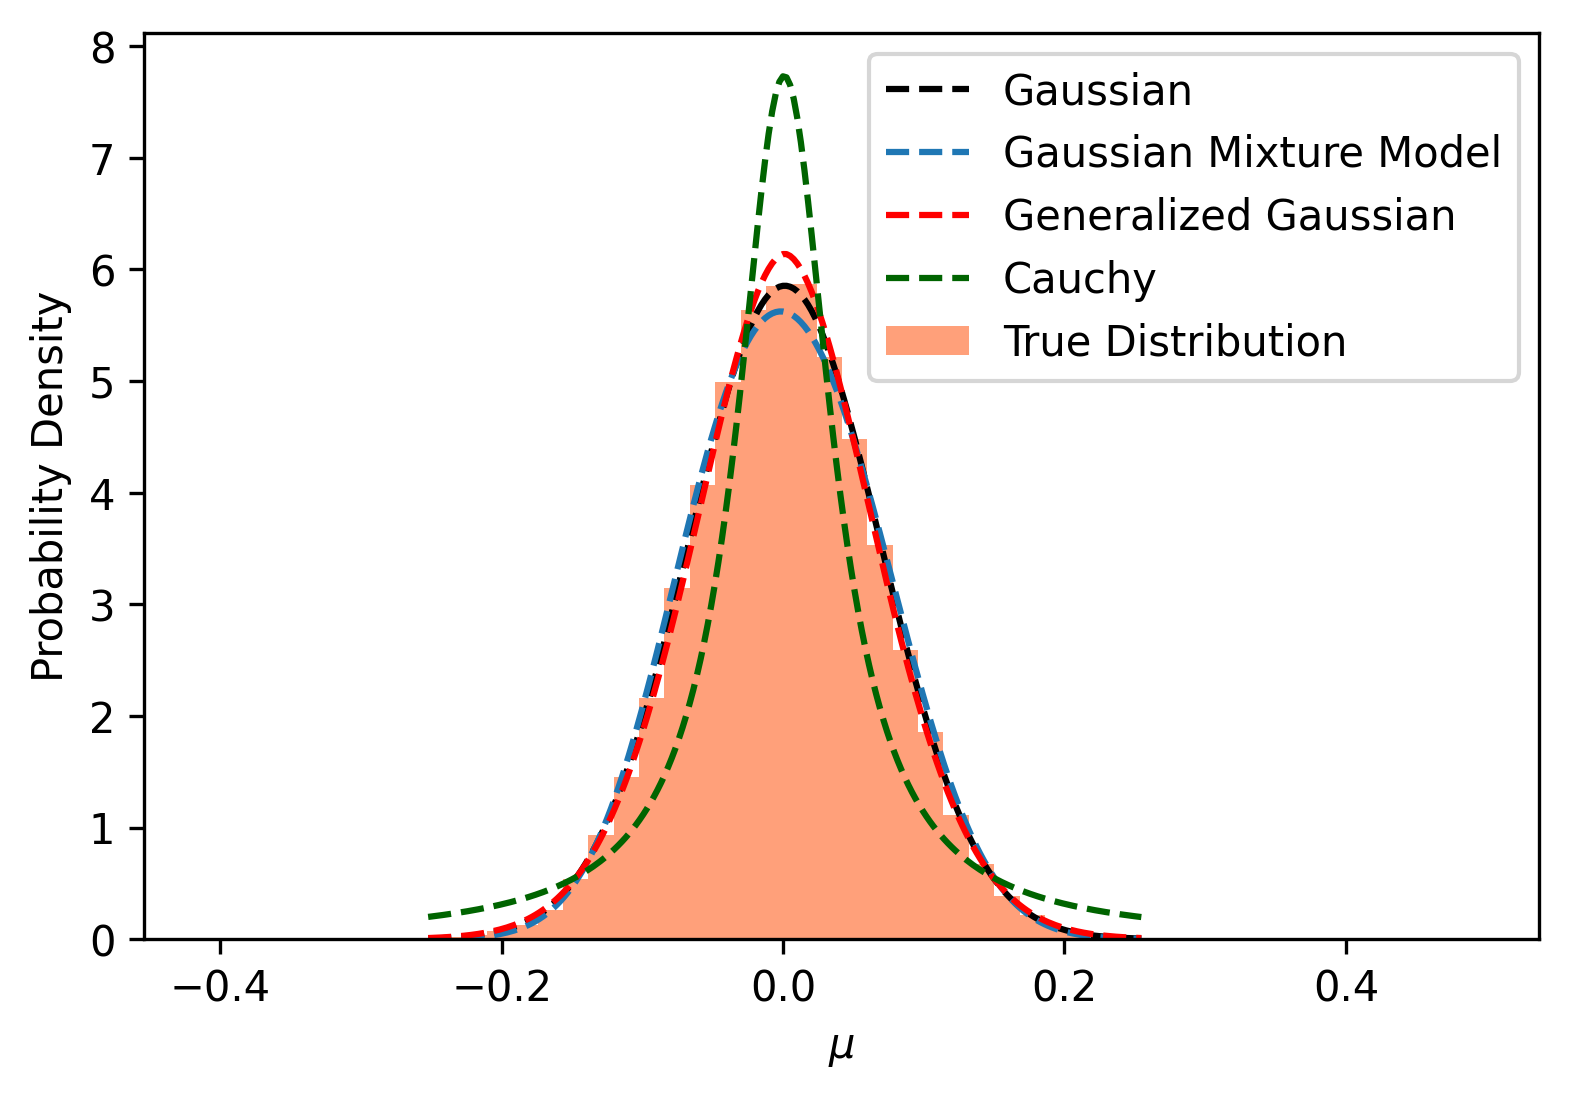

In [16]:
# hist和Gaussian approximation
empirical_mean = np.mean(whole_w)
empirical_std = np.std(whole_w)
plt.figure(dpi=300)
plt.hist(whole_w, bins=50, density= True, label='True Distribution',color='lightsalmon')
a = np.linspace(norm.ppf(0.0001, loc=empirical_mean, scale=empirical_std),norm.ppf(0.9999, loc=empirical_mean, scale=empirical_std), 200)
plt.plot(a, norm.pdf(a, loc=empirical_mean, scale=empirical_std), label = 'Gaussian', color='black', linestyle = 'dashed')
# 绘制GMM的概率密度函数曲线
plt.plot(a, np.exp(gmm.score_samples(a.reshape(-1, 1))), label = 'Gaussian Mixture Model', linestyle = 'dashed')
# 绘制GG的概率密度函数曲线
y_log = np.zeros(len(a))
for i in range(len(a)):
    y_log[i] = log_GGD_pdf (mu_est,alpha_est,beta_est,a[i])
y_est = np.exp(y_log)
plt.plot(a, y_est, label = 'Generalized Gaussian', color='r', linestyle = 'dashed')
# 绘制cauchy的概率密度函数曲线
plt.plot(a, cauchy.pdf(a, loc=cauchy_loc, scale=cauchy_scale), label = 'Cauchy', color = 'darkgreen', linestyle = 'dashed')
plt.xlabel('$\mu$')
plt.ylabel('Probability Density')
# plt.title('Distribution plot of $\mu$ in all layers')
plt.legend()
plt.show()

# 逐层画图

Best n_components (AIC): 2


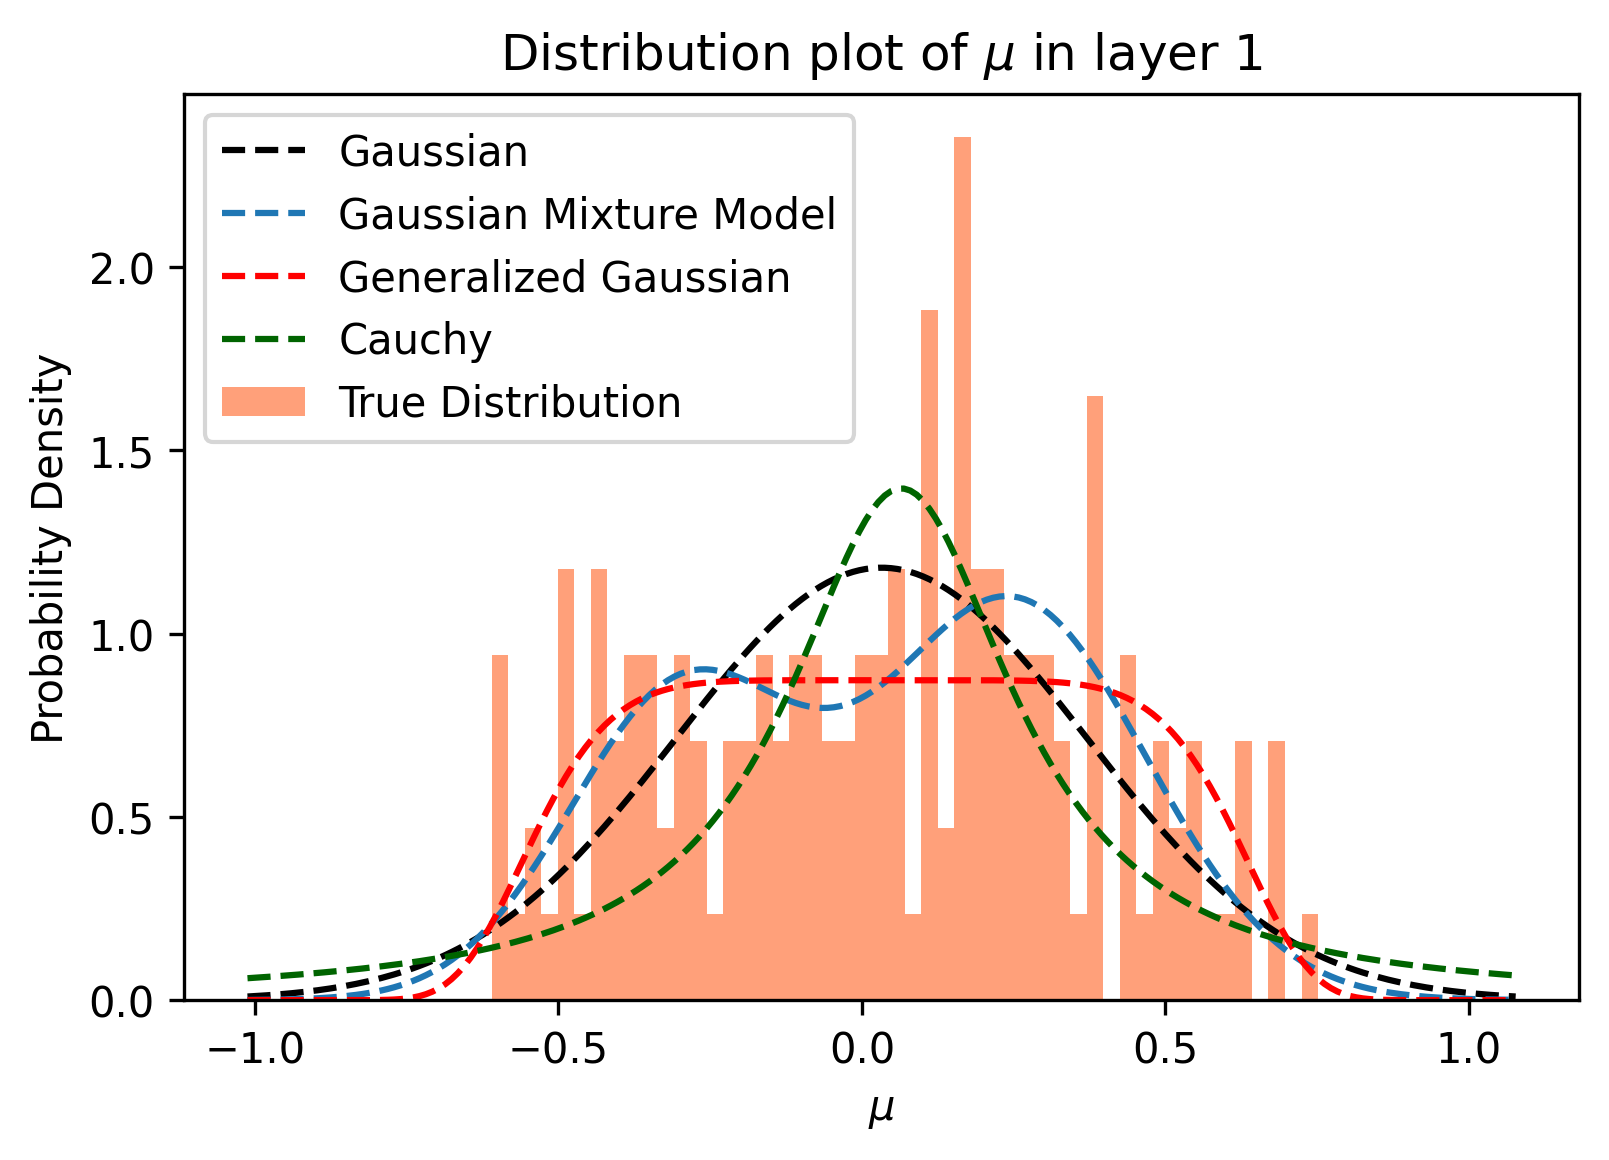

Best n_components (AIC): 3


/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


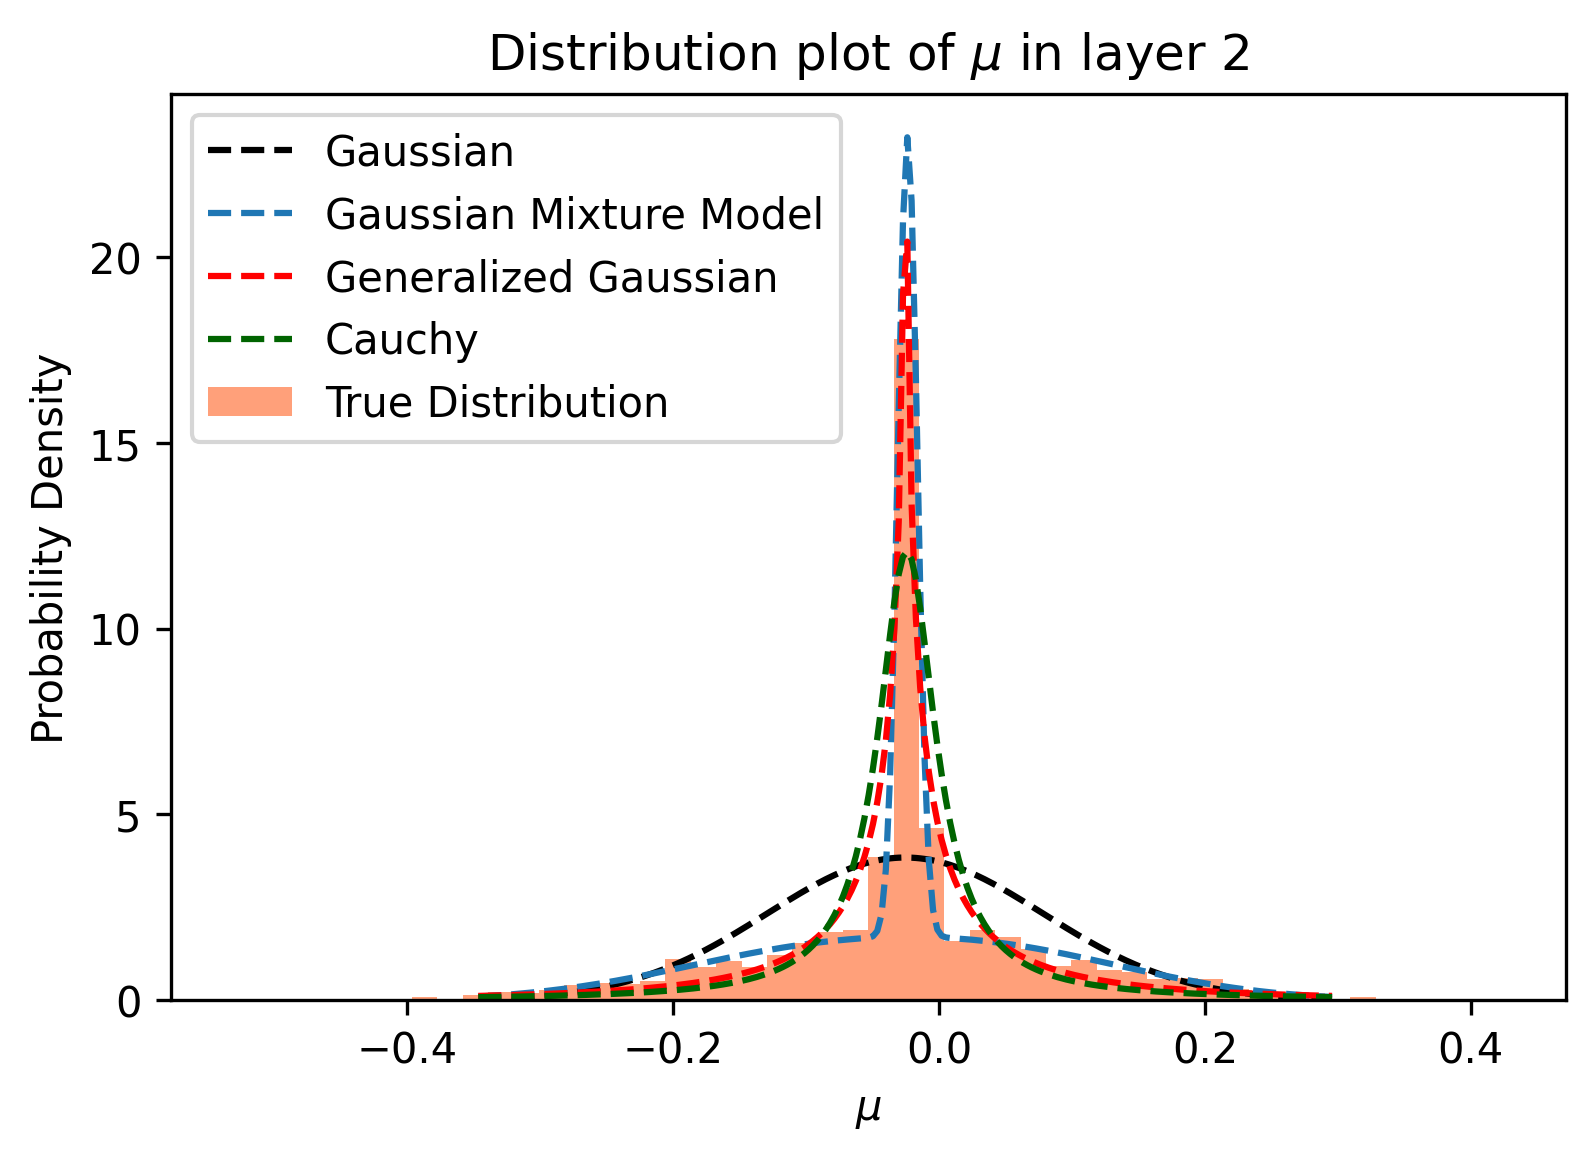

Best n_components (AIC): 4


/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


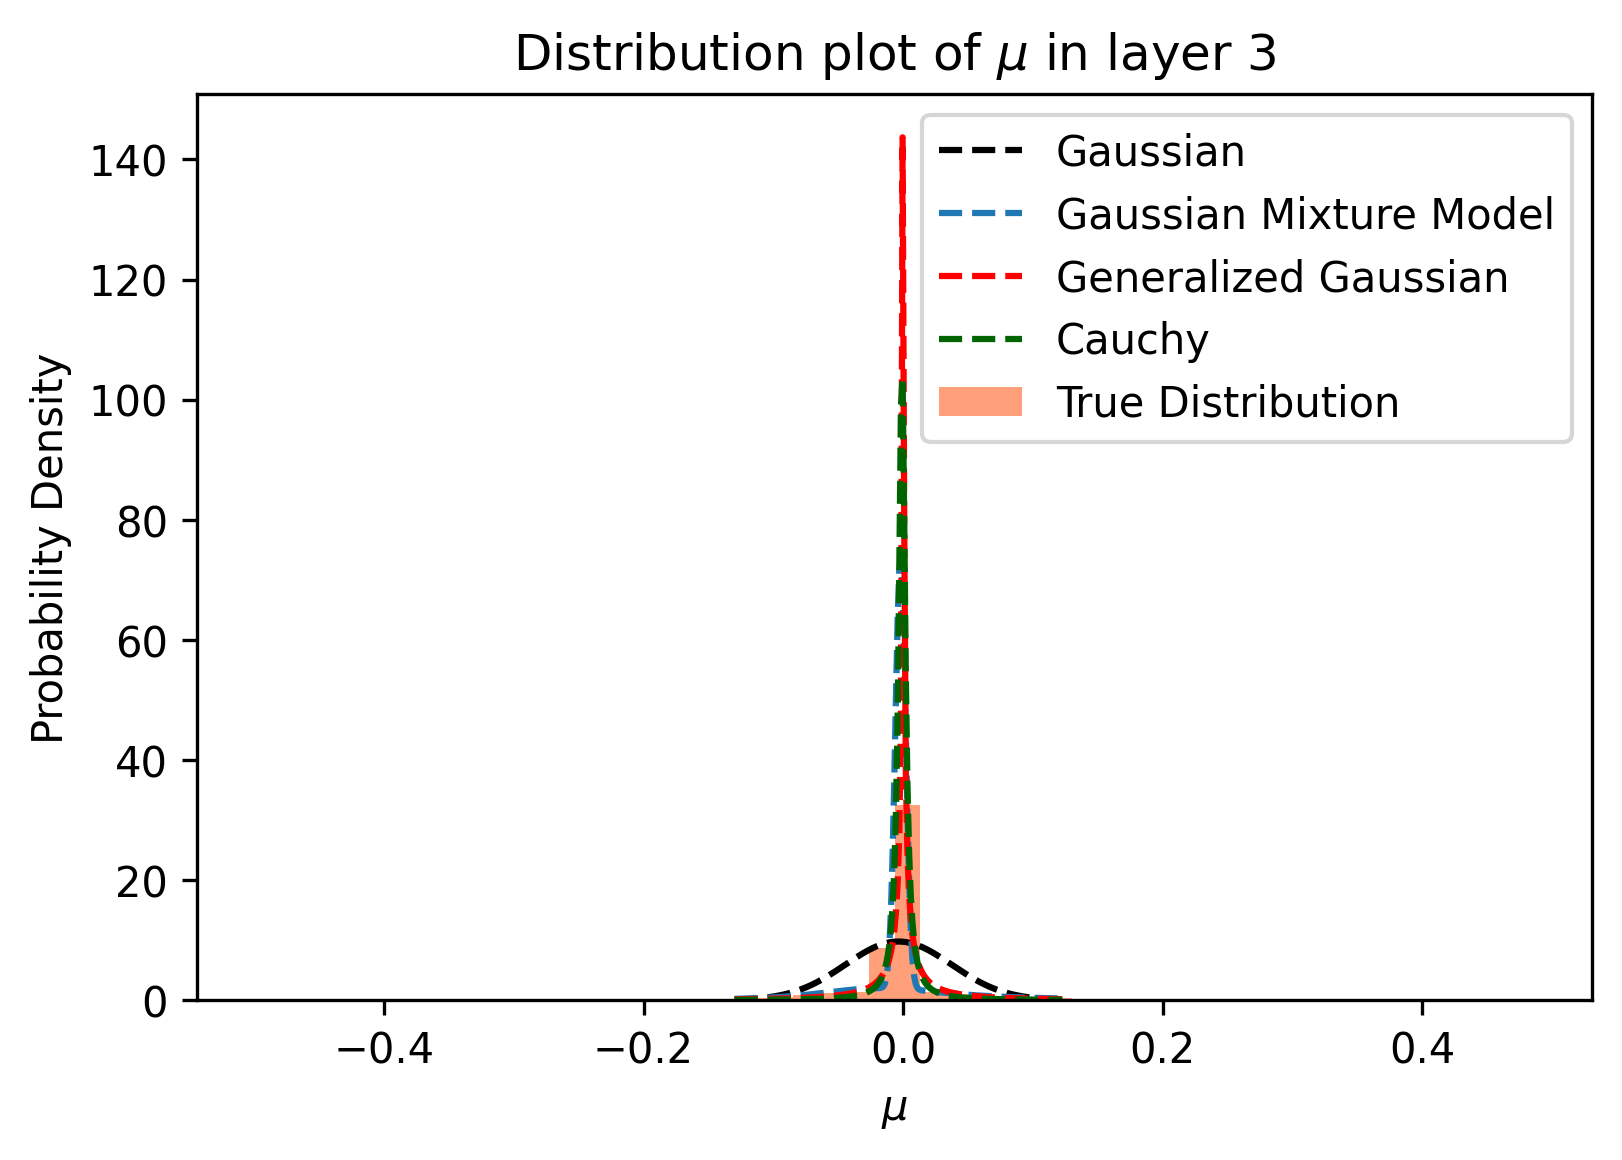

Best n_components (AIC): 5


/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


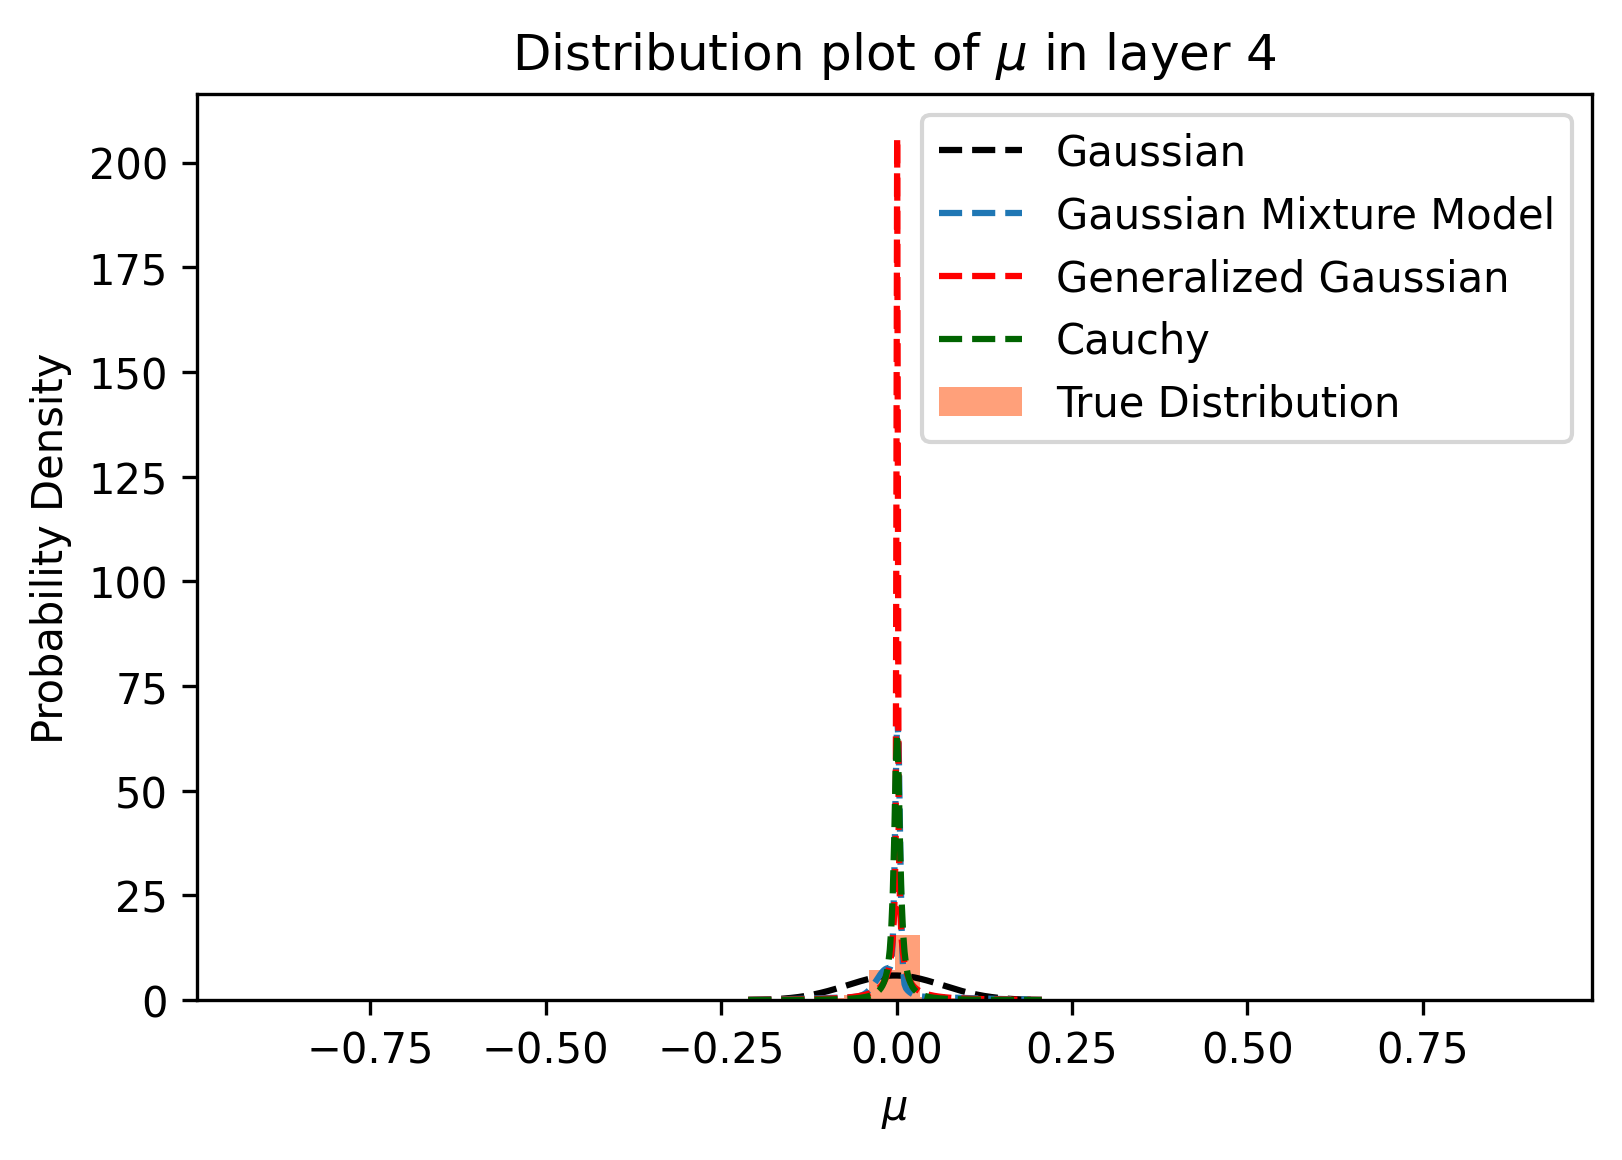

Best n_components (AIC): 5


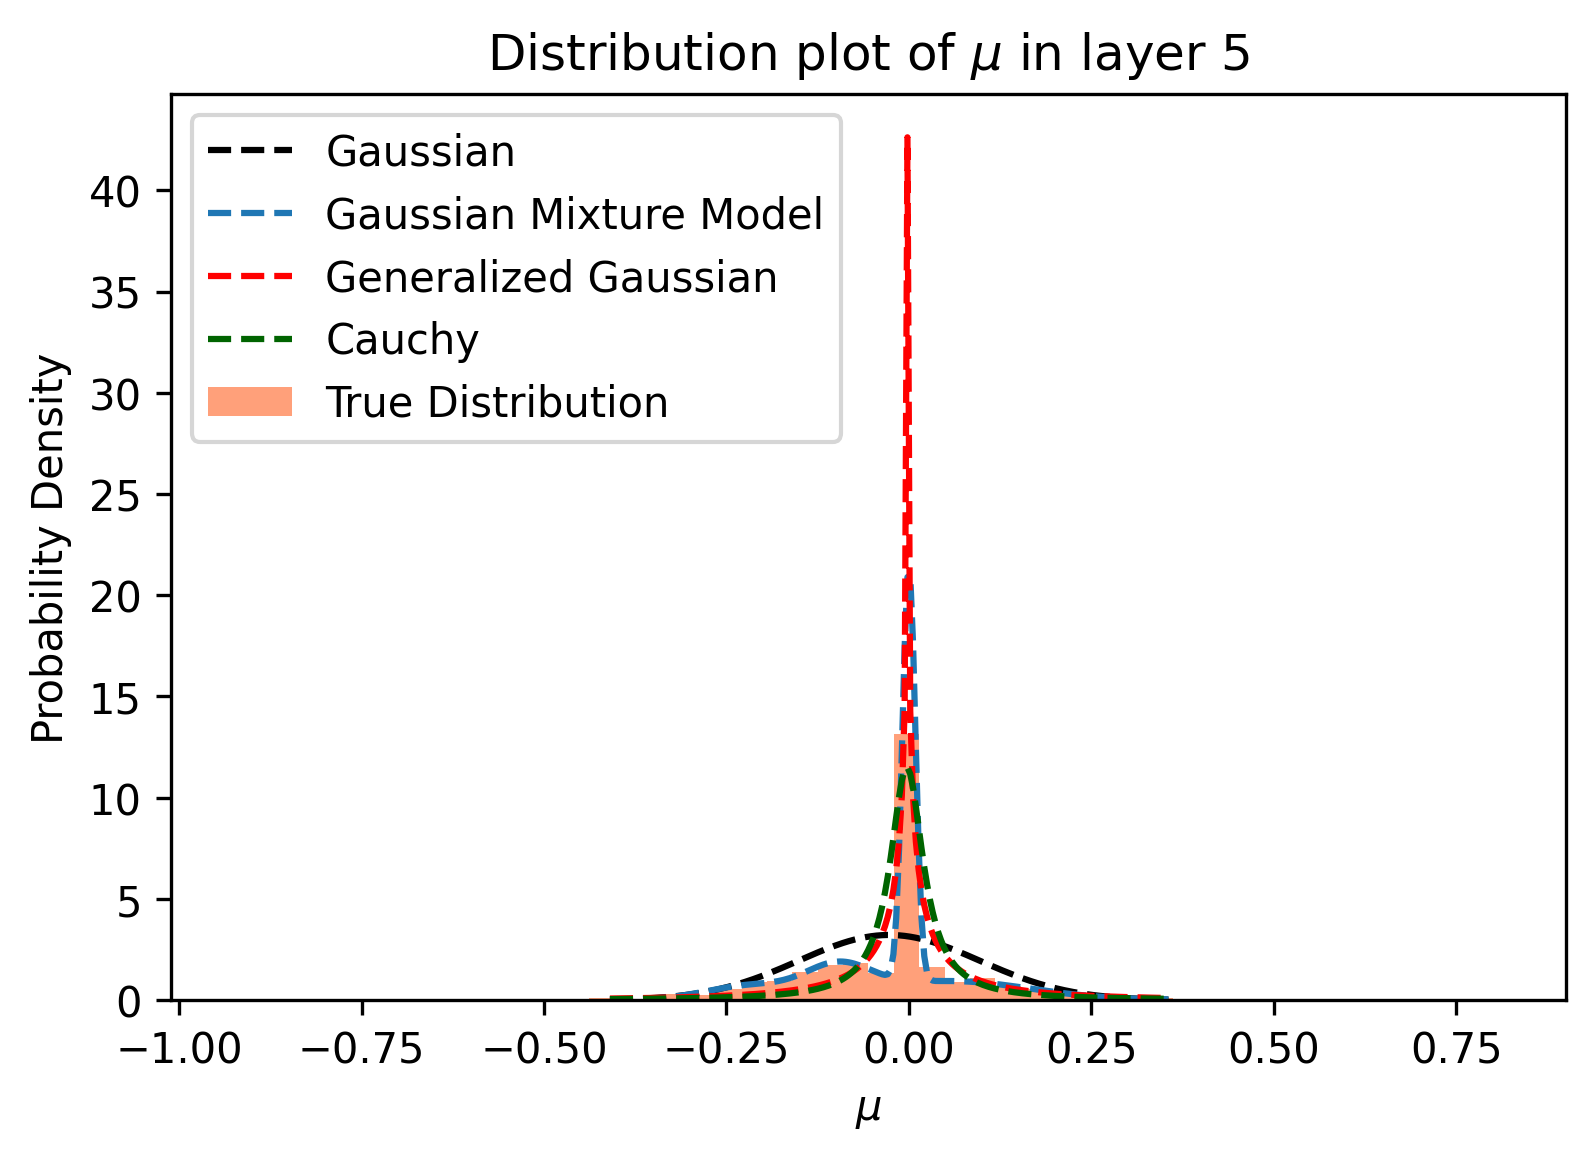

In [ ]:
for id, (i, j) in enumerate(zip(w_name, b_name)):
    vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
    vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
    vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
    # fit GMM
    # 定义要尝试的n_components值
    n_min = 2
    n_components_range = range(n_min, 6)

    # 初始化信息准则列表
    aic_scores = []
    bic_scores = []

    # 计算每个n_components值上的信息准则值
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(vecs_u.reshape(-1,1))
        aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
        # bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

    # 选择具有最小信息准则值的n_components值
    best_n_components_aic = np.argmin(aic_scores) + n_min
    # best_n_components_bic = np.argmin(bic_scores) + n_min

    print("Best n_components (AIC):", best_n_components_aic)
    # print("Best n_components (BIC):", best_n_components_bic)

    gmm = GaussianMixture(n_components=best_n_components_aic)
    gmm.fit(vecs_u.reshape(-1,1))

    # fit GG
    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u.ravel())

    # hist和Gaussian approximation
    empirical_mean = np.mean(vecs_u)
    empirical_std = np.std(vecs_u)
    plt.figure(dpi=300)
    plt.hist(vecs_u.ravel(), bins=50, density= True, label='True Distribution',color='lightsalmon')
    a = np.linspace(norm.ppf(0.001, loc=empirical_mean, scale=empirical_std),norm.ppf(0.999, loc=empirical_mean, scale=empirical_std), 200)
    plt.plot(a, norm.pdf(a, loc=empirical_mean, scale=empirical_std), label = 'Gaussian', color = 'black', linestyle = 'dashed')
    # 绘制GMM的概率密度函数曲线
    plt.plot(a, np.exp(gmm.score_samples(a.reshape(-1, 1))), label = 'Gaussian Mixture Model', linestyle = 'dashed')
    # 绘制GG的概率密度函数曲线
    y_log = np.zeros(len(a))
    for i in range(len(a)):
        y_log[i] = log_GGD_pdf (mu_est,alpha_est,beta_est,a[i])
    y_est = np.exp(y_log)
    plt.plot(a, y_est, label = 'Generalized Gaussian', color='r', linestyle = 'dashed')
    # 绘制cauchy的概率密度函数曲线
    cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
    plt.plot(a, cauchy.pdf(a, loc=cauchy_loc, scale=cauchy_scale), label = 'Cauchy', color = 'darkgreen', linestyle = 'dashed')
    plt.xlabel('$\mu$')
    plt.ylabel('Probability Density')
    plt.title('Distribution plot of $\mu$ in layer {}'.format(id+1))
    plt.legend()
    plt.show()
